In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

In [2]:
test2017_preds = pd.read_csv('datasets/client_results/7a_combined_model_new_arch_seq_classifier_tabular_features_10bins.csv',index_col=0)

/home/ambuj/izenda_fullcycle/environment/env/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
cleaned_loss_desc_df = pd.read_csv('hashed_cleaned_loss_desc_from_5_ipynb.csv',index_col=0)

In [4]:
cleaned_loss_desc_df.columns

Index(['EstimateTotal', 'LossDescription', 'hashed_loss_desc',
       'EstimateTotal_bins', 'hashed_loss_desc_len', 'hashed_loss_desc_padded',
       'LossYearMo'],
      dtype='object')

In [5]:
cleaned_loss_desc_df.rename({'LossDescription':'CleanedLossDescription'},axis=1,inplace=True)

# Getting cleaned loss desc column for test2017 data

In [6]:
test2017_preds_cleaned = pd.merge(test2017_preds,pd.DataFrame(cleaned_loss_desc_df[['CleanedLossDescription','hashed_loss_desc_len']]),left_index=True,right_index=True)

# Analysis 2

### We will split the clear test2017 predictions(max_proba > 0.5) into two parts:

#### 1) Right Predictions - Rows having difference of bins less than 5

#### 2) Wrong Predicions - Rows having difference of bins more than or equal to 5

Idea is to look for factors that are affecting the model to give big misses even when the model was confident about it being correct.

### Converting bins into numbers

In [7]:
clear_test2017_preds = test2017_preds_cleaned[test2017_preds_cleaned.max_probability > 0.5]

In [8]:
mapping_dict = {'a':1,'b':2,'c':3,'d':4,'e':5,'f':6,'g':7,'h':8,'i':9,'j':10}

In [9]:
clear_test2017_preds['EstimateTotal_bins_mapped'] = clear_test2017_preds['EstimateTotal_bins'].map(mapping_dict)
clear_test2017_preds['test2017_preds_names_mapped'] = clear_test2017_preds['test2017_preds_names'].map(mapping_dict)

/home/ambuj/izenda_fullcycle/environment/env/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ambuj/izenda_fullcycle/environment/env/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
right_clear_test2017_preds = clear_test2017_preds.where(abs(clear_test2017_preds['test2017_preds_names_mapped'] - clear_test2017_preds['EstimateTotal_bins_mapped']) < 5).dropna()

In [11]:
wrong_clear_test2017_preds = clear_test2017_preds.where(abs(clear_test2017_preds['test2017_preds_names_mapped'] - clear_test2017_preds['EstimateTotal_bins_mapped']) >= 5).dropna()

# 1) Getting frequency distribution of words in right and wrong predictions

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

### Right Predictions

In [13]:
right_vectorizer = CountVectorizer(token_pattern = r"(?u)\b\w+\b")

right_corpus = right_clear_test2017_preds['CleanedLossDescription']

right_sparse_matrix = right_vectorizer.fit_transform(right_corpus)

In [14]:
len(right_vectorizer.vocabulary_)

5106

In [15]:
right_features_count = right_sparse_matrix.sum(axis=0).tolist()[0]
right_features_names = right_vectorizer.get_feature_names()

right_features = pd.DataFrame()

right_features['feature'] = right_features_names
right_features['count'] = right_features_count
right_features = right_features.sort_values(by='count',ascending=False)

In [30]:
right_features['count_pct'] = right_features['count'] / right_clear_test2017_preds.shape[0] * 1000

In [16]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(right_features)

                feature  count
1121              damag   3512
4949              water   2668
3883               roof   2659
855               clean   2224
2587               leak   1967
707              carpet   1456
3888               room   1436
3053               need   1296
2147               home   1142
2303              insur   1128
1732               fire   1071
1765              floor   1047
2707               loss   1035
494               board    954
407             bedroom    910
5018               wind    904
3427              pleas    886
4114             shingl    886
736                caus    870
2502            kitchen    787
1357               door    735
666                call    718
2035               hail    713
2289            inspect    689
5020             window    673
381            bathroom    649
2168               hous    641
750                ceil    593
1422                due    583
4919               wall    562
3400               pipe    561
216     

### wrong Predictions

In [17]:
wrong_vectorizer = CountVectorizer(token_pattern = r"(?u)\b\w+\b")

wrong_corpus = wrong_clear_test2017_preds['CleanedLossDescription']

wrong_sparse_matrix = wrong_vectorizer.fit_transform(wrong_corpus)

In [18]:
len(wrong_vectorizer.vocabulary_)

1316

In [19]:
wrong_features_count = wrong_sparse_matrix.sum(axis=0).tolist()[0]
wrong_features_names = wrong_vectorizer.get_feature_names()

wrong_features = pd.DataFrame()

wrong_features['feature'] = wrong_features_names
wrong_features['count'] = wrong_features_count
wrong_features = wrong_features.sort_values(by='count',ascending=False)

In [31]:
wrong_features['count_pct'] = wrong_features['count'] / wrong_clear_test2017_preds.shape[0] * 1000

In [20]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(wrong_features)

            feature  count
304           damag    105
1015           roof    102
873           pleas    102
403           estim     76
779            need     73
222           clean     67
591         inspect     66
1277          water     66
692            loss     59
180            call     55
448            fire     50
561            home     49
1296           wind     47
1080         shingl     43
77           assist     42
75           assign     41
663            leak     40
597           insur     37
568            hous     35
456           floor     33
983          repair     32
189          carpet     31
245          compar     29
16           adjust     26
218           claim     26
1018           room     25
268         contact     25
641         kitchen     25
758            mold     24
194            caus     23
852             per     23
330        descript     23
987         request     22
1085           side     22
650          ladder     21
924          provid     21
6

#### Seeinng the words which are in both

In [21]:
len(set(wrong_features_names).intersection(set(right_features_names)))

1194

As, the words in both clear and unclear predictions are almost same.  
So, let us observe the words that are in one category but not in other.

#### Seeing the words which are in right but not in wrong

In [22]:
right_no_wrong_words = list(set(right_features_names) - set(wrong_features_names))

In [23]:
right_features[right_features.feature.isin(right_no_wrong_words)]

,feature,count
1943,glass,243
3180,om,209
4822,urin,183
3447,pod,173
1827,frame,165
462,bio,148
2040,hall,141
2720,lr,121
3356,pet,93
2683,lock,92


#### Seeing the words which are in wrong but not in right

In [24]:
wrong_no_right_words = list(set(wrong_features_names) - set(right_features_names))

In [25]:
wrong_features[wrong_features.feature.isin(wrong_no_right_words)]

,feature,count
962,redon,3
620,jenki,2
571,humboldt,2
1013,roman,2
661,lawyer,2
375,duncan,2
1124,spore,2
258,condominum,2
176,caa,2
1244,unnot,1


The words in wrong_no_right have very less counts. So, no conclusion drawn.  

#### Understanding contrast between right and wrong in terms of word occurence count

In [33]:
all_word_counts = pd.merge(right_features,wrong_features,left_on='feature',right_on='feature',how='outer')

In [34]:
all_word_counts.fillna(0,inplace=True)

In [35]:
all_word_counts.set_index('feature',inplace=True)

In [36]:
word_label_list = list(all_word_counts.index)

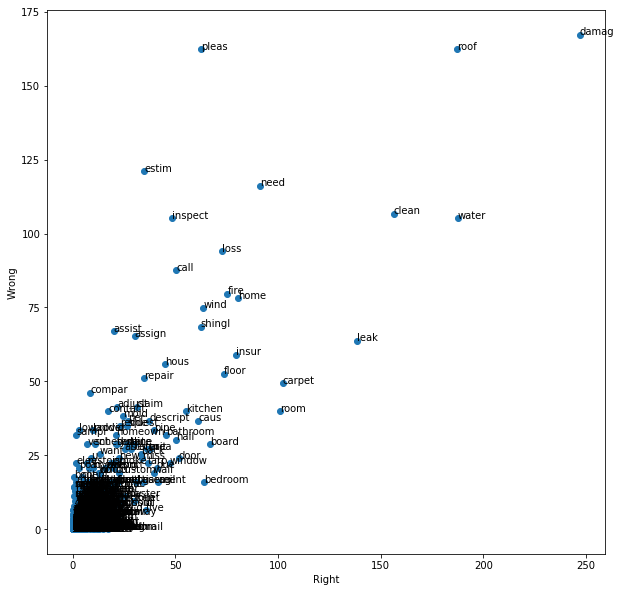

In [38]:
import matplotlib.pyplot as plt
import pylab
f, ax = plt.subplots(figsize=(10, 10))
x = all_word_counts['count_pct_x']
y = all_word_counts['count_pct_y']

plt.scatter(x,y)

for i, txt in enumerate(word_label_list):
    ax.annotate(txt, (x[i], y[i]))
    
plt.ylabel('Wrong')
plt.xlabel('Right')

plt.show()

In [39]:
all_word_counts['ratio'] = all_word_counts['count_pct_x'] / all_word_counts['count_pct_y']

In [116]:
all_word_counts_sub = all_word_counts[(all_word_counts.ratio != np.inf) & (all_word_counts.ratio != 0)]
all_word_counts_sub_y = all_word_counts_sub[(all_word_counts_sub.count_pct_y >= 10)]
all_word_counts_sub_x = all_word_counts_sub[(all_word_counts_sub.count_pct_x >= 10)]
# all_word_counts_sub.sort_values(by=['ratio', 'count_x'],ascending=False)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(all_word_counts.sort_values(by=['ratio'],ascending=True))

                   count_x  count_pct_x  count_y  count_pct_y      ratio
feature                                                                 
heath                  0.0     0.000000      1.0     1.592357   0.000000
compactor              0.0     0.000000      1.0     1.592357   0.000000
lvt                    0.0     0.000000      1.0     1.592357   0.000000
lynch                  0.0     0.000000      1.0     1.592357   0.000000
maggot                 0.0     0.000000      1.0     1.592357   0.000000
modifi                 0.0     0.000000      1.0     1.592357   0.000000
comfort                0.0     0.000000      1.0     1.592357   0.000000
clip                   0.0     0.000000      1.0     1.592357   0.000000
redon                  0.0     0.000000      3.0     4.777070   0.000000
clien                  0.0     0.000000      1.0     1.592357   0.000000
molit                  0.0     0.000000      1.0     1.592357   0.000000
os                     0.0     0.000000      1.0   

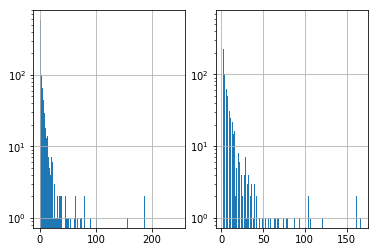

In [85]:
plt.subplot(1,2,1)
all_word_counts_sub['count_pct_x'].hist(bins = 200, log = True)

plt.subplot(1,2,2)
all_word_counts_sub['count_pct_y'].hist(bins = 150, log = True)

In [109]:
# top words correspond to those which contribute most to wrong
# bottom words correspond to those which contribute most to right
temp_y = all_word_counts_sub_y.sort_values(by=['ratio'],ascending=True)
temp_x = all_word_counts_sub_x.sort_values(by=['ratio'],ascending=True)
top_30_all_word_counts_sub = list(temp_y.head(30).index)
bottom_30_all_word_counts_sub = list(temp_x.tail(30).index)

#### Analyzing loss description length characteristics for right and wrong predictions

In [43]:
right_word_len_df = pd.DataFrame(right_clear_test2017_preds.hashed_loss_desc_len.value_counts())

right_word_len_df.rename({'hashed_loss_desc_len':'count'},axis=1,inplace=True)
right_word_len_df.index.name = 'loss_desc_len'

right_word_len_df = right_word_len_df.reset_index()

above_14 = right_word_len_df[right_word_len_df['loss_desc_len'] >=14]['count'].sum()

right_word_len_df = right_word_len_df[right_word_len_df['loss_desc_len'] <14]

right_word_len_df = right_word_len_df.append(pd.DataFrame({'loss_desc_len': [14], 'count': [above_14]}),sort=False).reset_index(drop=True)

right_word_len_df['pct'] = (right_word_len_df['count'] / right_clear_test2017_preds.shape[0]) * 100

right_word_len_df.sort_values(by=['pct'],ascending=False)

,loss_desc_len,count,pct
0,11.0,1772,12.460446
1,10.0,1741,12.242458
2,12.0,1307,9.190634
3,9.0,1291,9.078124
4,4.0,1099,7.728008
5,8.0,1066,7.495957
6,3.0,979,6.884185
7,5.0,958,6.736516
8,6.0,917,6.448210
9,2.0,887,6.237255


In [44]:
wrong_word_len_df = pd.DataFrame(wrong_clear_test2017_preds.hashed_loss_desc_len.value_counts())

wrong_word_len_df.rename({'hashed_loss_desc_len':'count'},axis=1,inplace=True)
wrong_word_len_df.index.name = 'loss_desc_len'

wrong_word_len_df = wrong_word_len_df.reset_index()

above_14 = wrong_word_len_df[wrong_word_len_df['loss_desc_len'] >=14]['count'].sum()

wrong_word_len_df = wrong_word_len_df[wrong_word_len_df['loss_desc_len'] <14]

wrong_word_len_df = wrong_word_len_df.append(pd.DataFrame({'loss_desc_len': [14], 'count': [above_14]}),sort=False).reset_index(drop=True)

wrong_word_len_df['pct'] = (wrong_word_len_df['count'] / wrong_clear_test2017_preds.shape[0]) * 100

wrong_word_len_df.sort_values(by=['pct'],ascending=False)

,loss_desc_len,count,pct
0,11.0,85,13.535032
1,9.0,83,13.216561
2,10.0,81,12.898089
3,12.0,48,7.643312
4,3.0,45,7.165605
5,8.0,42,6.687898
6,2.0,39,6.210191
7,13.0,38,6.050955
8,5.0,37,5.891720
9,7.0,37,5.891720


The top 5 length values in wrong preds have 4 lengths in common with the right preds.  
If there would have been a length(or lengths) that were contributing mostly to wrong preds would not have been present in top 5 in right preds.  
Hence, Length of loss desc has no specific length value that gives wrong predictions 

# 2) Getting State Distribution

In [46]:
right_states = set(right_clear_test2017_preds['State'].unique())

In [47]:
wrong_states = set(wrong_clear_test2017_preds['State'].unique())

In [48]:
right_clear_test2017_preds['State'].value_counts()

FL                              2783
CA                              1269
TX                              1173
MI                               688
IN                               657
NC                               635
OR                               570
ON                               540
GA                               526
MN                               497
VA                               307
PA                               278
OH                               270
IL                               257
ND                               255
CT                               226
IA                               209
WA                               208
AZ                               192
WI                               192
NY                               183
MD                               175
SC                               167
TN                               144
BC                               133
CO                               128
AR                               125
I

In [49]:
wrong_clear_test2017_preds['State'].value_counts()

FL    94
ON    48
NC    38
GA    37
CA    35
PA    27
MI    27
TX    25
IN    22
AL    21
TN    18
IL    17
WA    16
OH    15
SC    13
WI    12
AB    12
KY    11
AZ    10
OR     9
VA     8
MN     8
MD     8
CT     7
ID     6
MA     6
NJ     5
NY     5
HI     5
NE     5
NS     4
CO     4
MT     4
KS     4
AR     3
OK     3
MB     3
NH     3
QC     3
BC     3
DC     3
UT     2
AK     2
NB     2
NM     2
NV     2
ND     2
IA     2
SK     2
MS     2
WV     1
ME     1
MO     1
Name: State, dtype: int64

#### States which are in right but not in wrong

In [50]:
right_states - wrong_states

{'Australian Capital Territory',
 'DE',
 'LA',
 'NL',
 'NT',
 'PE',
 'RI',
 'SD',
 'VT',
 'WY'}

Though there are some states which are not from US, but their value_counts is small.  
For eg: Australian Capital Territory is in right but not in wrong. But there is only row of it in right.  
So, ignore them.

#### States which are in wrong but not in right

In [51]:
wrong_states - right_states

set()

#### Checking Scatter Plot of distribution of state in right and wrong

In [52]:
right_states_val_counts = pd.DataFrame(right_clear_test2017_preds['State'].value_counts())
right_states_val_counts.rename({'State':'count'},axis=1,inplace=True)
right_states_val_counts.index.name = 'State'
right_states_val_counts.reset_index(inplace=True)

In [55]:
right_states_val_counts['count_pct'] = right_states_val_counts['count'] / right_clear_test2017_preds.shape[0] * 1000

In [56]:
wrong_states_val_counts = pd.DataFrame(wrong_clear_test2017_preds['State'].value_counts())
wrong_states_val_counts.rename({'State':'count'},axis=1,inplace=True)
wrong_states_val_counts.index.name = 'State'
wrong_states_val_counts.reset_index(inplace=True)

In [58]:
wrong_states_val_counts['count_pct'] = wrong_states_val_counts['count'] / wrong_clear_test2017_preds.shape[0] * 1000

In [59]:
all_state_counts = pd.merge(right_states_val_counts,wrong_states_val_counts,left_on='State',right_on='State')

In [60]:
all_state_list = list(all_state_counts['State'])

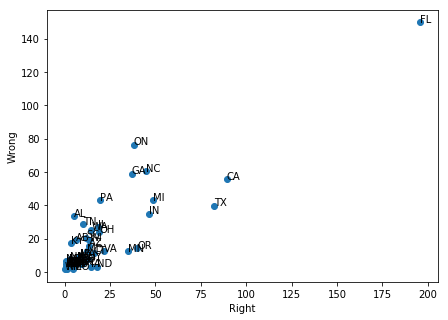

In [94]:
f, ax = plt.subplots(figsize=(7, 5))
x = all_state_counts['count_pct_x']
y = all_state_counts['count_pct_y']

plt.scatter(x,y)

for i, txt in enumerate(all_state_list):
    ax.annotate(txt, (x[i], y[i]))
    
plt.ylabel('Wrong')
plt.xlabel('Right')

plt.show()

No outlier state

In [120]:
all_state_counts['ratio'] = all_state_counts['count_pct_x'] / all_state_counts['count_pct_y']
all_state_counts.sort_values(by=['ratio'],ascending=True)

,State,count_x,count_pct_x,count_y,count_pct_y,ratio
52,WV,2,0.140637,1,1.592357,0.088320
50,NS,10,0.703185,4,6.369427,0.110400
34,AL,69,4.851979,21,33.439490,0.145097
51,AK,7,0.492230,2,3.184713,0.154560
48,NH,13,0.914141,3,4.777070,0.191360
39,KY,48,3.375290,11,17.515924,0.192698
49,NB,11,0.773504,2,3.184713,0.242880
32,AB,85,5.977076,12,19.108280,0.312800
23,TN,144,10.125870,18,28.662420,0.353280
44,MT,33,2.320512,4,6.369427,0.364320


# 3) Checking Month of Claim

In [77]:
right_month_df = pd.DataFrame(right_clear_test2017_preds['LossMo'].value_counts())
right_month_df.rename({'LossMo':'count'},axis=1,inplace=True)
right_month_df.index.name = 'LossMo'
right_month_df.reset_index(drop=False,inplace=True)
right_month_df['pct'] = (right_month_df['count'] / right_clear_test2017_preds.shape[0]) * 100

In [78]:
right_month_df

,LossMo,count,pct
0,9.0,1515,10.653259
1,3.0,1486,10.449335
2,1.0,1378,9.689895
3,6.0,1321,9.289080
4,5.0,1277,8.979678
5,4.0,1261,8.867168
6,7.0,1229,8.642149
7,8.0,1156,8.128824
8,10.0,1002,7.045918
9,2.0,968,6.806835


In [79]:
wrong_month_df = pd.DataFrame(wrong_clear_test2017_preds['LossMo'].value_counts())
wrong_month_df.rename({'LossMo':'count'},axis=1,inplace=True)
wrong_month_df.index.name = 'LossMo'
wrong_month_df.reset_index(drop=False,inplace=True)
wrong_month_df['pct'] = (wrong_month_df['count'] / wrong_clear_test2017_preds.shape[0]) * 100

In [80]:
wrong_month_df

,LossMo,count,pct
0,3.0,70,11.146497
1,5.0,68,10.828025
2,1.0,64,10.191083
3,9.0,62,9.872611
4,4.0,56,8.917197
5,11.0,52,8.280255
6,7.0,48,7.643312
7,2.0,45,7.165605
8,6.0,45,7.165605
9,12.0,43,6.847134


No outlier month in both right and wrong rows. So, month also doesn't affect much.

# 4) Checking CommOrRes

In [81]:
right_commorres_df = pd.DataFrame(right_clear_test2017_preds.CommOrRes.value_counts())
right_commorres_df.rename({'CommOrRes':'count'},axis=1,inplace=True)
right_commorres_df.index.name = 'CommOrRes'
right_commorres_df.reset_index(drop=False,inplace=True)
right_commorres_df['pct'] = (right_commorres_df['count'] / right_clear_test2017_preds.shape[0]) * 100

In [82]:
right_commorres_df

,CommOrRes,count,pct
0,Residential,11670,82.06174
1,Commercial,1618,11.37754
2,Other,933,6.56072


In [83]:
wrong_commorres_df = pd.DataFrame(wrong_clear_test2017_preds.CommOrRes.value_counts())
wrong_commorres_df.rename({'CommOrRes':'count'},axis=1,inplace=True)
wrong_commorres_df.index.name = 'CommOrRes'
wrong_commorres_df.reset_index(drop=False,inplace=True)
wrong_commorres_df['pct'] = (wrong_commorres_df['count'] / wrong_clear_test2017_preds.shape[0]) * 100

In [84]:
wrong_commorres_df

,CommOrRes,count,pct
0,Residential,502,79.936306
1,Commercial,95,15.127389
2,Other,31,4.936306


CommOrRess also has nearly same distribution in both.

# 4) Checking PolicyHolderType

In [85]:
right_PolicyHolderType_df = pd.DataFrame(right_clear_test2017_preds.PolicyHolderType.value_counts())
right_PolicyHolderType_df.rename({'PolicyHolderType':'count'},axis=1,inplace=True)
right_PolicyHolderType_df.index.name = 'PolicyHolderType'
right_PolicyHolderType_df.reset_index(drop=False,inplace=True)
right_PolicyHolderType_df['pct'] = (right_PolicyHolderType_df['count'] / right_clear_test2017_preds.shape[0]) * 100

In [86]:
right_PolicyHolderType_df

,PolicyHolderType,count,pct
0,Individual,11156,78.447367
1,Company,3065,21.552633


In [87]:
wrong_PolicyHolderType_df = pd.DataFrame(wrong_clear_test2017_preds.PolicyHolderType.value_counts())
wrong_PolicyHolderType_df.rename({'PolicyHolderType':'count'},axis=1,inplace=True)
wrong_PolicyHolderType_df.index.name = 'PolicyHolderType'
wrong_PolicyHolderType_df.reset_index(drop=False,inplace=True)
wrong_PolicyHolderType_df['pct'] = (wrong_PolicyHolderType_df['count'] / wrong_clear_test2017_preds.shape[0]) * 100

In [88]:
wrong_PolicyHolderType_df

,PolicyHolderType,count,pct
0,Individual,466,74.203822
1,Company,162,25.796178


PolicyHolderType also has nearly same distribution in both.

# 5) Checking Display Name

In [63]:
right_DisplayName_df = pd.DataFrame(right_clear_test2017_preds.DisplayName.value_counts())
right_DisplayName_df.rename({'DisplayName':'count'},axis=1,inplace=True)
right_DisplayName_df.index.name = 'DisplayName'
right_DisplayName_df.reset_index(drop=False,inplace=True)
right_DisplayName_df['pct'] = (right_DisplayName_df['count'] / right_clear_test2017_preds.shape[0]) * 1000

In [64]:
right_DisplayName_df

,DisplayName,count,pct
0,Default,3401,239.153365
1,Consulting,2816,198.017017
2,Structural Repairs,2573,180.929611
3,Temporary Services,1844,129.667393
4,Carpet Cleaning,1671,117.502285
5,Water Mitigation,719,50.559032
6,BioHazard,471,33.120034
7,Contents,310,21.798748
8,Structural Cleaning,117,8.227270
9,Res-Com Services,95,6.680262


In [65]:
wrong_DisplayName_df = pd.DataFrame(wrong_clear_test2017_preds.DisplayName.value_counts())
wrong_DisplayName_df.rename({'DisplayName':'count'},axis=1,inplace=True)
wrong_DisplayName_df.index.name = 'DisplayName'
wrong_DisplayName_df.reset_index(drop=False,inplace=True)
wrong_DisplayName_df['pct'] = (wrong_DisplayName_df['count'] / wrong_clear_test2017_preds.shape[0]) * 1000

In [66]:
wrong_DisplayName_df

,DisplayName,count,pct
0,Default,209,332.802548
1,Structural Repairs,150,238.853503
2,Consulting,77,122.611465
3,Water Mitigation,66,105.095541
4,Temporary Services,42,66.878981
5,Contents,29,46.178344
6,Carpet Cleaning,20,31.847134
7,Structural Cleaning,12,19.108280
8,Res-Com Services,7,11.146497
9,Mold Remediation,6,9.554140


#### Checking distribution of Display Name using Scatter Plot

In [67]:
all_display_name_counts = pd.merge(right_DisplayName_df,wrong_DisplayName_df,left_on='DisplayName',right_on='DisplayName')

In [68]:
all_display_name_list = list(all_display_name_counts['DisplayName'])

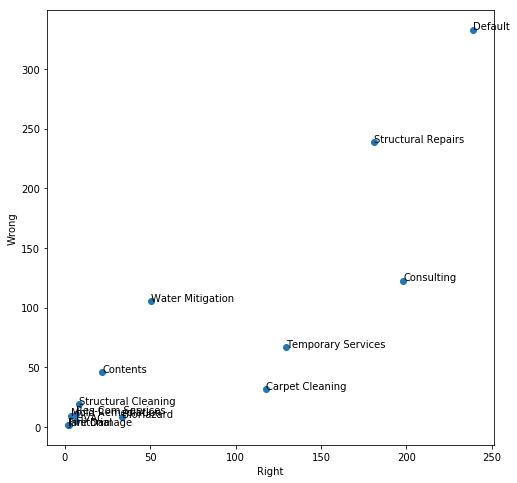

In [96]:
f, ax = plt.subplots(figsize=(8, 8))
x = all_display_name_counts['pct_x']
y = all_display_name_counts['pct_y']

plt.scatter(x,y)

for i, txt in enumerate(all_display_name_list):
    ax.annotate(txt, (x[i], y[i]))
    
plt.ylabel('Wrong')
plt.xlabel('Right')

plt.show()

In [70]:
all_display_name_counts['ratio'] = all_display_name_counts['pct_x'] / all_display_name_counts['pct_y']
all_display_name_counts.sort_values(by=['ratio'],ascending=True)

,DisplayName,count_x,pct_x,count_y,pct_y,ratio
11,Mold Remediation,49,3.445609,6,9.554140,0.360640
8,Structural Cleaning,117,8.227270,12,19.108280,0.430560
7,Contents,310,21.798748,29,46.178344,0.472056
5,Water Mitigation,719,50.559032,66,105.095541,0.481077
9,Res-Com Services,95,6.680262,7,11.146497,0.599315
0,Default,3401,239.153365,209,332.802548,0.718604
2,Structural Repairs,2573,180.929611,150,238.853503,0.757492
13,Fire Damage,21,1.476689,1,1.592357,0.927361
10,HVAC,89,6.258350,3,4.777070,1.310081
12,Janitorial,31,2.179875,1,1.592357,1.368961


No outlier DisplayName

# 6) Checking Division Name

In [72]:
right_DivisionName_df = pd.DataFrame(right_clear_test2017_preds.DivisionName.value_counts())
right_DivisionName_df.rename({'DivisionName':'count'},axis=1,inplace=True)
right_DivisionName_df.index.name = 'DivisionName'
right_DivisionName_df.reset_index(drop=False,inplace=True)
right_DivisionName_df['pct'] = (right_DivisionName_df['count'] / right_clear_test2017_preds.shape[0]) * 1000

In [73]:
right_DivisionName_df

,DivisionName,count,pct
0,Carpet Cleaning,1426,100.274242
1,Inspections,1120,78.756768
2,Reconstruction,988,69.474720
3,Plumbing,920,64.693060
4,TX Inspections,687,48.308839
5,Structure,536,37.690739
6,Temporary Repairs,403,28.338373
7,1-800 Board Up,378,26.580409
8,Structural Repairs,317,22.290978
9,Property Improvement,295,20.743970


In [74]:
wrong_DivisionName_df = pd.DataFrame(wrong_clear_test2017_preds.DivisionName.value_counts())
wrong_DivisionName_df.rename({'DivisionName':'count'},axis=1,inplace=True)
wrong_DivisionName_df.index.name = 'DivisionName'
wrong_DivisionName_df.reset_index(drop=False,inplace=True)
wrong_DivisionName_df['pct'] = (wrong_DivisionName_df['count'] / wrong_clear_test2017_preds.shape[0]) * 1000

In [75]:
wrong_DivisionName_df

,DivisionName,count,pct
0,Reconstruction,53,84.394904
1,Property Improvement,37,58.917197
2,Inspection,28,44.585987
3,Plumbing,26,41.401274
4,Structural Repairs,25,39.808917
5,Consulting,25,39.808917
6,Structure,23,36.624204
7,Water Mitigation,20,31.847134
8,Comparative/Peer Review Only,19,30.254777
9,Consulting,18,28.662420


#### Checking distribution of Division Name using Scatter Plot

In [76]:
all_Division_name_counts = pd.merge(right_DivisionName_df,wrong_DivisionName_df,left_on='DivisionName',right_on='DivisionName')

In [77]:
all_Division_name_list = list(all_Division_name_counts['DivisionName'])

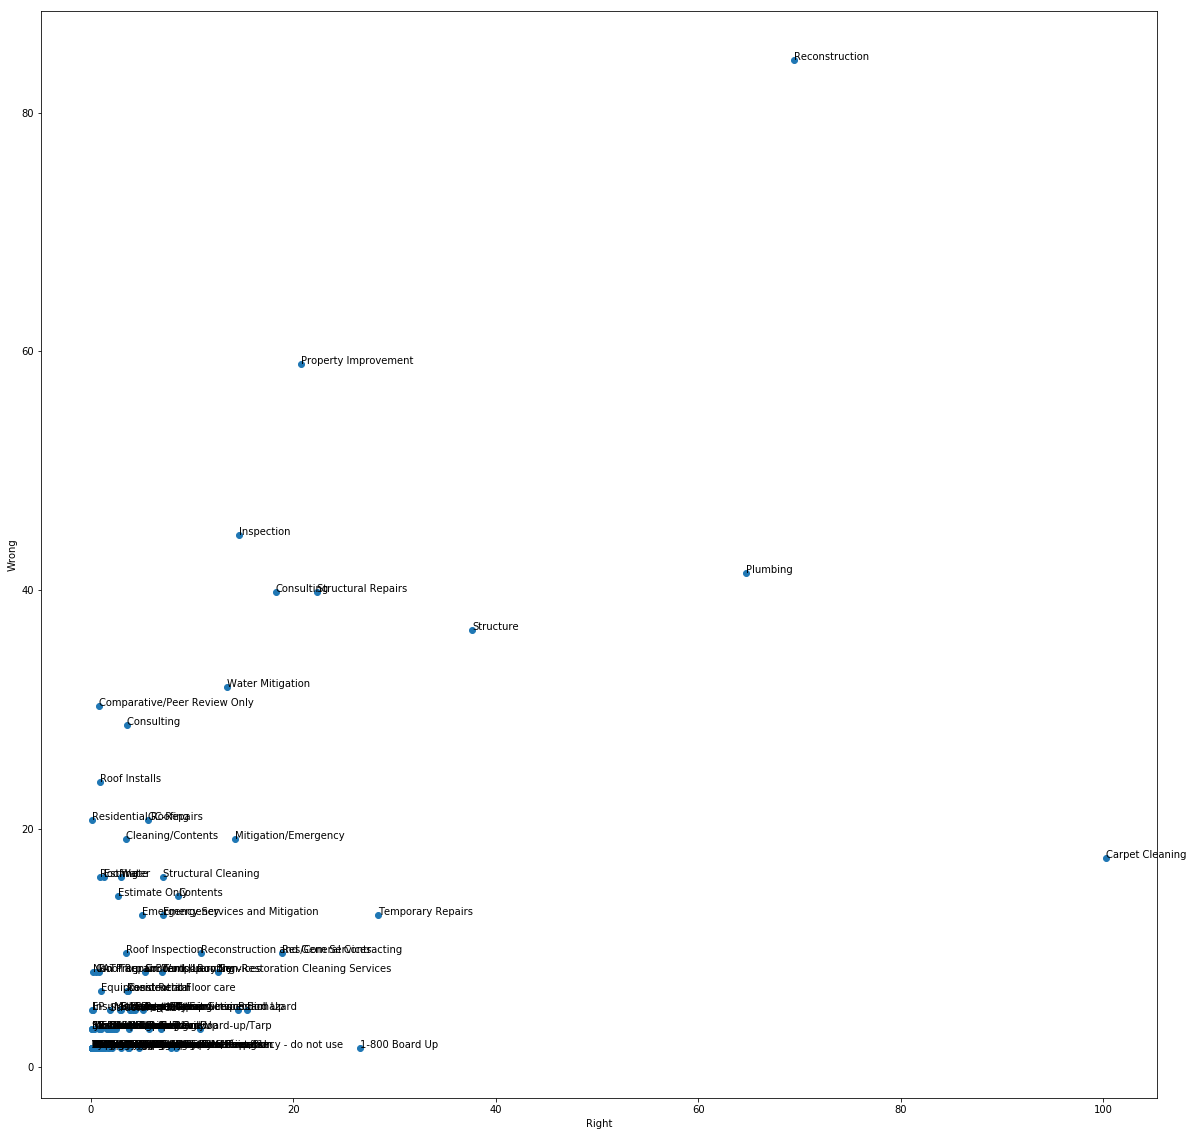

In [78]:
f, ax = plt.subplots(figsize=(20, 20))
x = all_Division_name_counts['pct_x']
y = all_Division_name_counts['pct_y']

plt.scatter(x,y)

for i, txt in enumerate(all_Division_name_list):
    ax.annotate(txt, (x[i], y[i]))
    
plt.ylabel('Wrong')
plt.xlabel('Right')

plt.show()

In [98]:
pd.set_option('display.max_rows', None)

In [99]:
all_Division_name_counts['ratio'] = all_Division_name_counts['pct_x'] / all_Division_name_counts['pct_y']
all_Division_name_counts.sort_values(by=['ratio'],ascending=True)

,DivisionName,count_x,pct_x,count_y,pct_y,ratio
114,Residential Roofing,1,0.070319,13,20.700637,0.003397
115,Move Back,1,0.070319,2,3.184713,0.022080
104,Structural Cleaning,1,0.070319,2,3.184713,0.022080
102,EP - Water Rebuild,1,0.070319,2,3.184713,0.022080
94,Non Program Work - Roofing,3,0.210956,5,7.961783,0.026496
72,Comparative/Peer Review Only,12,0.843823,19,30.254777,0.027891
101,EP - Mold Remediation,2,0.140637,3,4.777070,0.029440
67,Roof Installs,13,0.914141,15,23.885350,0.038272
107,Mold,1,0.070319,1,1.592357,0.044160
103,Water Loss,1,0.070319,1,1.592357,0.044160


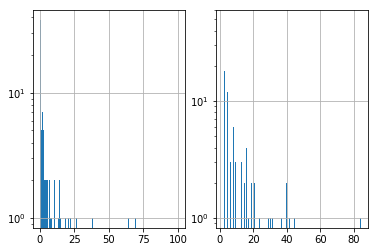

In [97]:
plt.subplot(1,2,1)
all_Division_name_counts['pct_x'].hist(bins = 200, log = True)

plt.subplot(1,2,2)
all_Division_name_counts['pct_y'].hist(bins = 150, log = True)

In [104]:
all_Division_name_counts[(all_Division_name_counts.pct_y >10) &(all_Division_name_counts.ratio < 0.2)]

,DivisionName,count_x,pct_x,count_y,pct_y,ratio
40,Consulting,51,3.586246,18,28.662420,0.125120
42,Cleaning/Contents,49,3.445609,12,19.108280,0.180320
44,Water,42,2.953379,10,15.923567,0.185472
47,Estimate Only,38,2.672105,9,14.331210,0.186454
61,Estimate,18,1.265734,10,15.923567,0.079488
67,Roof Installs,13,0.914141,15,23.885350,0.038272
68,Roofing,13,0.914141,10,15.923567,0.057408
72,Comparative/Peer Review Only,12,0.843823,19,30.254777,0.027891
114,Residential Roofing,1,0.070319,13,20.700637,0.003397


#### Towards Wrong:
['Consulting ', 'Cleaning/Contents ', 'Water', 'Estimate Only',
       'Estimate', 'Roof Installs', 'Roofing',
       'Comparative/Peer Review Only', 'Residential Roofing']

In [106]:
all_Division_name_counts[(all_Division_name_counts.pct_x >10) &(all_Division_name_counts.ratio > 3)]

,DivisionName,count_x,pct_x,count_y,pct_y,ratio
0,Carpet Cleaning,1426,100.274242,11,17.515924,5.724748
5,1-800 Board Up,378,26.580409,1,1.592357,16.692497
10,Biohazard,219,15.399761,3,4.777070,3.223683
12,Board Up,206,14.485620,3,4.777070,3.032323
17,Board-up/Tarp,153,10.758737,2,3.184713,3.378243


#### Towards Right:
['Carpet Cleaning', '1-800 Board Up', 'Biohazard', 'Board Up',
       'Board-up/Tarp']